<a href="https://colab.research.google.com/github/utkarshkant/Bank-Complaints-Text-Classification/blob/main/Text_Classification_Bank_Complaints_H2O_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install h20
!apt-get install default-jre
!java -version
!pip install h2o

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
     |████████████████████████████████| 129.4MB 88kB/s 
  Created wheel for h2o: filename=h2o-3.30.1.3-py2.py3-none-any.whl size=129446676 sha256=a7533213d4eb86a56cd48ec2e5aa52fa62a7c5488f771df4b1424b4ee9751589
  Stored in directory: /root/.cache/pip/wheels/3d/e6/07/53ce9be9cb61b33a79cb3ed1fc39f2dae84f6ee6fe1e373e5e
Successfully built h2o


In [ ]:
# imports
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML

In [ ]:
# configurations
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [ ]:
# initialize h2o cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.8" 2020-07-14; OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpk_6h_unp
  JVM stdout: /tmp/tmpk_6h_unp/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpk_6h_unp/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,"7 days, 1 hour and 14 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_dbn6aa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [ ]:
# download punkt corpus
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# download training data
df = pd.read_csv("https://github.com/utkarshkant/Bank-Complaints-Text-Classification/blob/main/consumer_compliants.zip?raw=true", compression='zip', sep=",", quotechar='"')

In [ ]:
# preview dataset
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Company has responded to the consumer and the CFPB and chooses not to provide a public response,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter 

In [ ]:
# size of dataset
df.shape

(57453, 18)

In [ ]:
df['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                       9799 
Checking or savings account    7003 
Student loan                   2950 
Vehicle loan or lease          2736 
Name: Product, dtype: int64

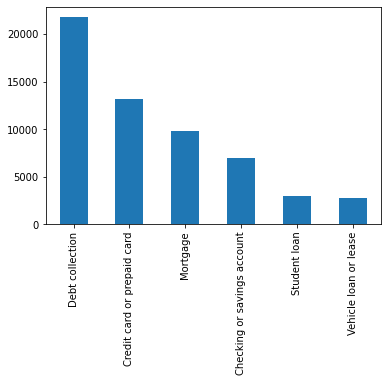

In [ ]:
df['Product'].value_counts().plot(kind='bar')

In [ ]:
df['Company'].value_counts()

CITIBANK, N.A.                           3226
CAPITAL ONE FINANCIAL CORPORATION        2711
BANK OF AMERICA, NATIONAL ASSOCIATION    2580
JPMORGAN CHASE & CO.                     2409
WELLS FARGO & COMPANY                    2001
                                         ... 
National Finance Company, Inc.           1   
RLB Texas Auto Center LLC                1   
St.John Cobb Inc                         1   
Happy Money, Inc.                        1   
JFQ Lending, Inc.                        1   
Name: Company, Length: 2197, dtype: int64

- Dataset is imbalanced

In [ ]:
# filter dataset
complaints_df = df[['Consumer complaint narrative', 'Product', 'Company']].rename(columns={'Consumer complaint narrative':'Complaints'})

In [ ]:
# preview dataset
complaints_df.head()

,Complaints,Product,Company
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked and they never

`Product` variable is our target variable that we need to into numerical values for the model

In [ ]:
complaints_df['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                       9799 
Checking or savings account    7003 
Student loan                   2950 
Vehicle loan or lease          2736 
Name: Product, dtype: int64

In [ ]:
# encode target variable

# create value mapper
target_mapper = {
    "Debt collection":0,
    "Credit card or prepaid card":1,
    "Mortgage":2,
    "Checking or savings account":3,
    "Student loan":4,
    "Vehicle loan or lease":5
}
# map encoding
complaints_df['Target'] = complaints_df['Product'].map(target_mapper)

In [ ]:
# preview dataset
complaints_df.head(3)

,Complaints,Product,Company,Target
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,5
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings,0
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,5


In [ ]:
# train test split
X_train, X_test = train_test_split(complaints_df, test_size=0.8, random_state=111)

In [ ]:
# stemmer
# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

In [ ]:
# stopwords
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# UDF for data preprocessing
def tokenize(text):
  # tokenization
  tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))))]
  tokens = map(str.lower, tokens)
  # stemming
  stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
  return stems

In [ ]:
# word vectorizer
vectorizer_tf = TfidfVectorizer(tokenizer=tokenize, # UDF for more flexibility
                                stop_words=None,    # already removed
                                max_df=0.75,        # only count if words appear for at least 75% of the corpus
                                max_features=1000,  # max 1000 features
                                lowercase=False,    # already converted into lowercase
                                ngram_range=(1,2))        # 1 or 2
# pass train data
train_vectors = vectorizer_tf.fit_transform(X_train['Complaints'])

In [ ]:
# preview vector
train_vectors.A   # most values are 0 since it gets value only if the words occur there

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.47303244, 0.        , ..., 0.        , 0.        ,
        0.085629  ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# get tokens - feature names
vectorizer_tf.get_feature_names()

['0.00',
 '100.00',
 '1000.00',
 '1500.00',
 '200.00',
 '2000.00',
 '300.00',
 '500.00',
 'abil',
 'abl',
 'absolut',
 'abus',
 'accept',
 'access',
 'accord',
 'account',
 'account account',
 'account balanc',
 'account call',
 'account close',
 'account credit',
 'account number',
 'account open',
 'account report',
 'account would',
 'accru',
 'acct',
 'accur',
 'acknowledg',
 'action',
 'activ',
 'actual',
 'ad',
 'addit',
 'address',
 'adjust',
 'admit',
 'advanc',
 'advertis',
 'advis',
 'affect',
 'affidavit',
 'afford',
 'agenc',
 'agent',
 'agre',
 'agreement',
 'alert',
 'alleg',
 'alleg debt',
 'alli',
 'allow',
 'almost',
 'along',
 'alreadi',
 'also',
 'although',
 'alway',
 'america',
 'american',
 'american express',
 'amex',
 'amount',
 'amount owe',
 'and/or',
 'annual',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appeal',
 'appear',
 'appli',
 'applic',
 'apprais',
 'appreci',
 'approv',
 'approxim',
 'around',
 'arrang',
 'arriv',
 'ask',
 'ask spe

In [ ]:
test_vectors = vectorizer_tf.transform(X_test['Complaints'])

In [ ]:
print(X_train.shape)
print(X_test.shape)

(11490, 4)
(45963, 4)


In [ ]:
X_train.head(3)

,Complaints,Product,Company,Target
33773,I am a victim of identity theft and this debt does not belong to me. Please see the identity theft report and legal affidavit attached.,Debt collection,"Receivable Solutions, Inc.",0
51635,My wife went to see a vehicle that she really wanted. I was at work and when I got home she told me she felt so pressured to sign papers even though it was not under her name. The guys at the dealer force her to get the car under my name without my authorization. I went to the dealer fought them about it and unfortunately could do anything about it.,Vehicle loan or lease,"Reliable Credit Association, Inc.",5
52896,"Please see the attached imaces i have attached as proof. Please ask Telechek to get my information correct before i file fraud charges against them. I have asked them 4 times allready. The info is as follows : Business account name : XXXX XXXX XXXX XXXX account address : XXXX XXXX XXXX XXXX, KY XXXX Business phone number : ( XXXX ) XXXX",Checking or savings account,FISERV INC.,3


In [ ]:
# create dataframe - BOW
train_df = pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
train_df = pd.concat([train_df, X_train['Target'].reset_index(drop=True)], axis=1)
test_df = pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
test_df = pd.concat([test_df, X_test['Target'].reset_index(drop=True)], axis=1)

In [ ]:
# preview data
train_df.head()

,0.00,100.00,1000.00,1500.00,200.00,2000.00,300.00,500.00,abil,abl,absolut,abus,accept,access,accord,account,account account,account balanc,account call,account close,account credit,account number,account open,account report,account would,accru,acct,accur,acknowledg,action,activ,actual,ad,addit,address,adjust,admit,advanc,advertis,advis,...,verif,verifi,victim,victim ident,violat,visa,visit,voicemail,wait,waiv,want,websit,week,week later,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,worri,would,would call,would like,would receiv,would take,write,written,wrong,wrote,year,Target
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.234946,0.264949,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.159249,0.0,0.000000,0.0,0.0,0.0,0.355523,0.0,0.0,0.261219,0.0,0.0,0.0,0.0,0.0,0.171037,0.0,0.164042,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.194342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.194708,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3
3,0.0,0.070298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.14834,0.0,0.0,0.0,0.070028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108538,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.044738,0.0,0.000000,0.0,0.029707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064835,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.064063,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.062091,0.0,0.238206,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052983,5


In [ ]:
# preview data
test_df.head()

,0.00,100.00,1000.00,1500.00,200.00,2000.00,300.00,500.00,abil,abl,absolut,abus,accept,access,accord,account,account account,account balanc,account call,account close,account credit,account number,account open,account report,account would,accru,acct,accur,acknowledg,action,activ,actual,ad,addit,address,adjust,admit,advanc,advertis,advis,...,verif,verifi,victim,victim ident,violat,visa,visit,voicemail,wait,waiv,want,websit,week,week later,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,worri,would,would call,would like,would receiv,would take,write,written,wrong,wrote,year,Target
0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.087145,0.0,0.0,0.0,0.212928,0.0,0.348356,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045395,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043053,0.0,0.0,0.0,0.086738,0.0,0.000000,0.0,0.0,0.079771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110833,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.123490,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.155461,0.0,0.0,0.0,0.000000,0.0,0.233042,0.0,0.0,0.0,0.204688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1
3,0.094533,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.087797,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.033249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.058258,0.0,0.044491,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037221,0.0,0.0,0.044686,0.0,0.0,0.0,0.0,0.0,0.071748,4
4,0.000000,0.0,0.0,0.0,0.0,0.132864,0.0,0.0,0.0,0.079676,0.0,0.0,0.0,0.000000,0.0,0.039813,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.130224,1


In [ ]:
# drop few features
train_df.drop(['0.00',	'100.00',	'1000.00',	'1500.00',	'200.00',	'2000.00',	'300.00', '500.00'], axis=1, inplace=True)
test_df.drop(['0.00',	'100.00',	'1000.00',	'1500.00',	'200.00',	'2000.00',	'300.00', '500.00'], axis=1, inplace=True)

In [ ]:
# preview data
train_df.head(3)

,abil,abl,absolut,abus,accept,access,accord,account,account account,account balanc,account call,account close,account credit,account number,account open,account report,account would,accru,acct,accur,acknowledg,action,activ,actual,ad,addit,address,adjust,admit,advanc,advertis,advis,affect,affidavit,afford,agenc,agent,agre,agreement,alert,...,verif,verifi,victim,victim ident,violat,visa,visit,voicemail,wait,waiv,want,websit,week,week later,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,worri,would,would call,would like,would receiv,would take,write,written,wrong,wrote,year,Target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.267511,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.234946,0.264949,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.159249,0.0,0.0,0.0,0.0,0.0,0.355523,0.0,0.0,0.261219,0.0,0.0,0.0,0.0,0.0,0.171037,0.0,0.164042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.194342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.194708,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [ ]:
# model select with h2o 
h2o_train_df = h2o.H2OFrame(train_df)
h2o_test_df = h2o.H2OFrame(test_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
# ensure that the target column is in enumeration and not numeric (integer,real) so that the model understands that it is a classification problem and not a regression problem
h2o_train_df.types  

{'Target': 'int',
 'abil': 'real',
 'abl': 'real',
 'absolut': 'real',
 'abus': 'real',
 'accept': 'real',
 'access': 'real',
 'accord': 'real',
 'account': 'real',
 'account account': 'real',
 'account balanc': 'real',
 'account call': 'real',
 'account close': 'real',
 'account credit': 'real',
 'account number': 'real',
 'account open': 'real',
 'account report': 'real',
 'account would': 'real',
 'accru': 'real',
 'acct': 'real',
 'accur': 'real',
 'acknowledg': 'real',
 'action': 'real',
 'activ': 'real',
 'actual': 'real',
 'ad': 'real',
 'addit': 'real',
 'address': 'real',
 'adjust': 'real',
 'admit': 'real',
 'advanc': 'real',
 'advertis': 'real',
 'advis': 'real',
 'affect': 'real',
 'affidavit': 'real',
 'afford': 'real',
 'agenc': 'real',
 'agent': 'real',
 'agre': 'real',
 'agreement': 'real',
 'alert': 'real',
 'alleg': 'real',
 'alleg debt': 'real',
 'alli': 'real',
 'allow': 'real',
 'almost': 'real',
 'along': 'real',
 'alreadi': 'real',
 'also': 'real',
 'although': '

In [ ]:
# model selection
aml = H2OAutoML(max_models=10,
                seed=10,
                exclude_algos=['StackedEnsemble'],
                verbosity="info",
                nfolds=0,
                balance_classes=True,
                max_after_balance_size=0.3)

In [ ]:
a = ['a','b','c','d']
a.remove('d')
a

['a', 'b', 'c']

In [ ]:
# X and y spit
x = []
for i in train_df.columns:
  x.append(i)
x.remove('Target')

y = 'Target'

In [ ]:
# train automl
aml.train(x=x, 
          y=y, 
          training_frame=h2o_train_df, 
          validation_frame=h2o_test_df)

AutoML progress: |
16:47:44.708: Project: AutoML_20201005_164744704
16:47:44.709: Cross-validation disabled by user: no fold column nor nfolds > 1.
16:47:44.711: Setting stopping tolerance adaptively based on the training frame: 0.00932910509720565
16:47:44.711: Build control seed: 10
16:47:44.711: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
16:47:47.337: training frame: Frame key: automl_training_Key_Frame__upload_bb92c801efa4eea76e6848854fb64e7e.hex    cols: 993    rows: 10334  chunks: 14    size: 8637602  checksum: -215203914147201836
16:47:47.339: validation frame: Frame key: Key_Frame__upload_bc040acdcb47f753557a63823ad94acd.hex    cols: 993    rows: 45963  chunks: 53    size: 38208521  checksum: -3279517314266240642
16:47:47.548: leaderboard frame: Frame key: automl_leaderboard_Key_Frame__upload_bb92c801efa4eea76e6848854fb64e7e.hex    cols: 993    rows: 115

In [ ]:
# model leaderboard
aml.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_4_AutoML_20201005_164744,0.798289,0.89347,0.798289,0.55929,0.375452
DRF_1_AutoML_20201005_164744,0.805538,0.897518,0.805538,0.536747,0.37209
GBM_3_AutoML_20201005_164744,0.812209,0.901226,0.812209,0.569151,0.378949
GBM_2_AutoML_20201005_164744,0.818898,0.90493,0.818898,0.574715,0.384058
GBM_1_AutoML_20201005_164744,0.827989,0.909939,0.827989,0.58948,0.386922
GBM_5_AutoML_20201005_164744,0.87368,0.934708,0.87368,0.605913,0.390086
XGBoost_2_AutoML_20201005_164744,0.884761,0.940617,0.884761,0.60567,0.412883
XGBoost_3_AutoML_20201005_164744,0.90752,0.952639,0.90752,0.629804,0.412762
XGBoost_1_AutoML_20201005_164744,0.947165,0.973224,0.947165,0.628829,0.415334
GLM_1_AutoML_20201005_164744,0.976693,0.988278,0.976693,0.711968,nan


In [ ]:
# make predictions
pred = aml.leader.predict(h2o_test_df)
# evaluate model performance
aml.leader.model_performance(h2o_test_df)

gbm prediction progress: |████████████████████████████████████████████████| 100%

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.7636798903649158
RMSE: 0.8738878019316414
MAE: 0.5417842276700541
RMSLE: 0.3637569590633133
Mean Residual Deviance: 0.7636798903649158


In [ ]:
# get model ids
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# convert h2o hyperparameters to XGBoost parameters and get output
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])
out

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20201005_164744


Model Summary: 


,,number_of_trees
0,,35.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.2499864060298849
RMSE: 0.49998640584508386
MAE: 0.3265630847795895
RMSLE: 0.23965500509972953
Mean Residual Deviance: 0.2499864060298849

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.866605376443284
RMSE: 0.9309164175388056
MAE: 0.6067584974211578
RMSLE: NaN
Mean Residual Deviance: 0.866605376443284

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2020-10-05 16:48:23,0.008 sec,0.0,1.706597,1.261951,2.912473,1.698923,1.258675,2.886338
1,,2020-10-05 16:48:28,4.983 sec,5.0,0.824301,0.537826,0.679472,0.982705,0.640972,0.965709
2,,2020-10-05 16:48:31,8.440 sec,10.0,0.660623,0.410186,0.436423,0.924136,0.579178,0.854028
3,,2020-10-05 16:48:35,12.339 sec,15.0,0.615337,0.390366,0.378639,0.920859,0.584512,0.847980
4,,2020-10-05 16:48:38,15.635 sec,20.0,0.579352,0.371325,0.335649,0.921370,0.589627,0.848923
5,,2020-10-05 16:48:42,19.026 sec,25.0,0.550202,0.355120,0.302722,0.925168,0.596055,0.855936
6,,2020-10-05 16:48:45,22.518 sec,30.0,0.529515,0.344159,0.280386,0.927322,0.600667,0.859925
7,,2020-10-05 16:48:49,26.057 sec,35.0,0.499986,0.326563,0.249986,0.930916,0.606758,0.866605



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,debt,4962.558594,1.000000,0.173861
1,loan,2615.269775,0.527000,0.091625
2,collect,1223.222778,0.246490,0.042855
3,credit,1110.233643,0.223722,0.038897
4,bank,884.256958,0.178186,0.030980
5,mortgag,700.356628,0.141128,0.024537
6,payment,696.342773,0.140319,0.024396
7,vehicl,693.444519,0.139735,0.024295
8,card,688.517029,0.138742,0.024122
9,account,509.316284,0.102632,0.017844



See the whole table with table.as_data_frame()


In [ ]:
# parameters utilized
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'alpha': 0.0,
  'booster': 'gbtree',
  'colsample_bylevel': 0.8,
  'colsample_bytree': 0.8,
  'eta': 0.3,
  'gamma': 0.0,
  'grow_policy': 'depthwise',
  'lambda': 1.0,
  'max_delta_step': 0.0,
  'max_depth': 20,
  'min_child_weight': 10.0,
  'nround': 10000,
  'nthread': 2,
  'objective': 'reg:squarederror',
  'seed': 11,
  'silent': True,
  'subsample': 0.6,
  'tree_method': 'exact'},
 10000)

In [ ]:
# run a XGBoost model
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# instantiate classifier
xgb_clf = xgb.XGBClassifier(n_estimators=100, # total trees
                            learning_rate=0.05, # rate of learning
                            max_depth=6, # depth of each tree
                            objective='reg:squarederror',
                            random_state=10,
                            )

In [ ]:
# train model
xgb_clf.fit(train_vectors, X_train['Target'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# make predictions
predictions = xgb_clf.predict(test_vectors)
# evaluate model
print(confusion_matrix(X_test['Target'], predictions))
print()
print(f"Classification Report:\n{classification_report(X_test['Target'], predictions)}")

[[15947   720   260   160   178   164]
 [ 1064  8868    53   447    12    41]
 [  496   145  7086    91    57    70]
 [  382   623    74  4453     8    22]
 [  297   100    76     9  1839    45]
 [  472   207   105    38    30  1324]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     17429
           1       0.83      0.85      0.84     10485
           2       0.93      0.89      0.91      7945
           3       0.86      0.80      0.83      5562
           4       0.87      0.78      0.82      2366
           5       0.79      0.61      0.69      2176

    accuracy                           0.86     45963
   macro avg       0.85      0.81      0.83     45963
weighted avg       0.86      0.86      0.86     45963



In [ ]:
# class weights to tackle classs imbalance
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                                       np.unique(X_train['Target']),
                                                       X_train['Target']))
print(class_weights)

[0.44093944278148745, 0.7071639586410635, 1.0329018338727076, 1.328938237335184, 3.279109589041096, 3.419642857142857]


In [ ]:
# assign these weights in the same size of training matrix
weights = np.ones(X_train.shape[0], dtype='float')
print(weights)
for i, val in enumerate(X_train['Target']):
  weights[i] = class_weights[val]
print(weights)

[1. 1. 1. ... 1. 1. 1.]
[0.44093944 3.41964286 1.32893824 ... 0.70716396 0.70716396 1.03290183]


In [ ]:
# instantiate classifier
xgb_clf = xgb.XGBClassifier(n_estimators=100, # total trees
                            learning_rate=0.05, # rate of learning
                            max_depth=6, # depth of each tree
                            objective='reg:squarederror',
                            random_state=10,
                            )
# model training
xgb_clf.fit(train_vectors, X_train['Target'], sample_weight=weights)
# predictions
predictions = xgb_clf.predict(test_vectors)
# evaluate model
print(confusion_matrix(X_test['Target'], predictions))
print()
print(f"Classification Report:\n{classification_report(X_test['Target'], predictions)}")

[[14924   816   330   409   329   621]
 [  681  8565    81   749    88   321]
 [  180    77  7031   121   243   293]
 [  131   429    77  4818    20    87]
 [  134    25    35    14  2022   136]
 [  205    70    49    44   106  1702]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     17429
           1       0.86      0.82      0.84     10485
           2       0.92      0.88      0.90      7945
           3       0.78      0.87      0.82      5562
           4       0.72      0.85      0.78      2366
           5       0.54      0.78      0.64      2176

    accuracy                           0.85     45963
   macro avg       0.79      0.84      0.81     45963
weighted avg       0.86      0.85      0.85     45963



Model performance has improved
